In [1]:
import cv2
import skimage

import numpy as np
import matplotlib.pyplot as plt

Thresholding and filtering are fundamental concepts in the field of computer vision, playing a crucial role in image processing and analysis. Thresholding is segmenting an image into distinct regions based on pixel intensity values. This method is commonly used to separate objects of interest from their background. However, presence of noise or details that we are not interested in can hinder thresholding performance. We can use filtering to overcome this problem. Filtering, is used to enhance or suppress certain features within an image by applying various convolution operations. As you know, convolutions form the basis of CNNs. In this notebook we will first explore thresholding and then see how filtering can help improve thresholding performance. In the previous notebook you have already seen thresholding, but as you will see there is much more to it.

1. Simple Thresholding
2. Otsu Thresholding
3. Adaptive Thresholding
4. Filtering Images


## 1. Simple Thresholding

Previously we used logical operators (`<` and `>`) for thresholding. OpenCV has a function to do the same with additional functionality:


```thresh, binary_im = cv2.threshold(src, thresh, maxval, type)```

Parameters
- `src`: input image
- `thresh`: threshold value
- `maxval`: maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types.
- `type`: thresholding type

Returns
- `thresh`:  the threshold value that was used
- `binary_im`: the resulting binary image after applying the thresholding operation.

Read the [documentation](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576) for different thresholding types.

Let's take a look at the first type, `cv2.THRESH_BINARY`. In this thresholding type, all the pixel values above `thresh` are set to `maxval`, the rest are set to 0.

We know that in our _coins_ image the background is 255 and the darker shades are the coins. So let's select a threshold of 250 and see what happens:


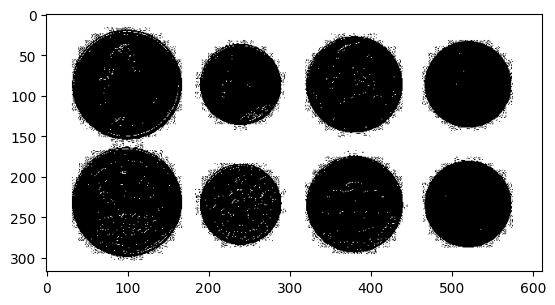

In [5]:
im = cv2.imread('images/coins.jpeg', 0)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY)
plt.imshow(output_im, cmap='gray')

As you can see, thresholding indeed can help us separate objects from the background. The quality is okay but not great. There are some pixels at the edges that are set to 0 but they belong to the background causing fuziness at the edges. There are some pixels on the coin that are set to 255 but actually belong to the coin. In the other sections of this notebook, you will see how we can deal with that using filtering.

In object detection, by convention, the object you want to detect is labeled as 1 or 255 and the background as 0. We can do that with the thresholding type `cv2.THRESH_BINARY_INV`

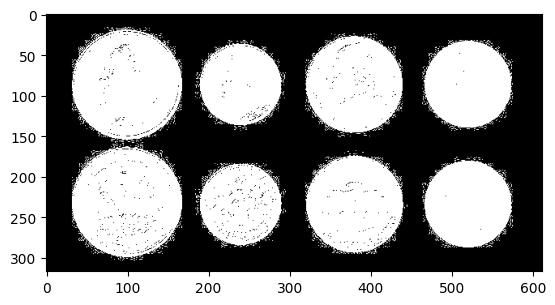

In [6]:
im = cv2.imread('images/coins.jpeg', 0)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV)
plt.imshow(output_im, cmap='gray')

so we simply get the inverted binary image.

**Exercise 2.1**

Apply `cv2.threshold()` to the cell image. Try various thresholds to find the best one that separates the cell from the background.

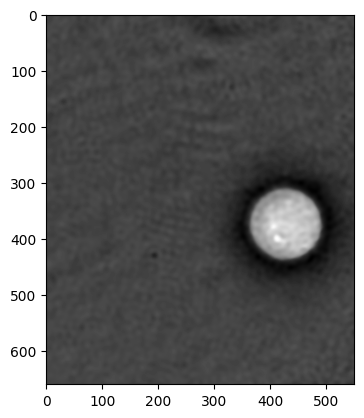

In [4]:
im_cell = skimage.data.cell()
plt.imshow(im_cell, cmap='gray')

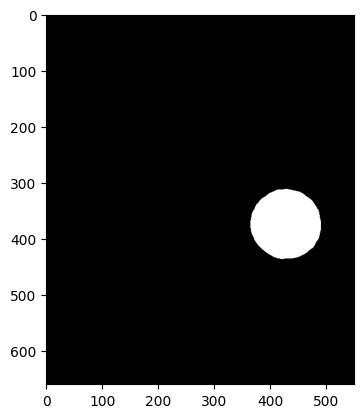

In [7]:
# YOUR CODE HERE
thresh, binary_im = cv2.threshold(im_cell, 100, 255, cv2.THRESH_BINARY)
plt.imshow(binary_im, cmap = 'grey')

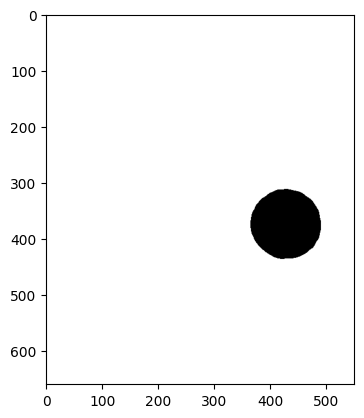

In [8]:
thresh, binary_im = cv2.threshold(im_cell, 100, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary_im, cmap = 'grey')

## 2. Otsu Thresholding

In Exercise 2.1 you changed the threshold manually, observed the output and changed it again iteratively to find an ideal threshold. Is there a way to select a threshold automatically? This is what Otsu thresholding does so that we don't have to select the threshold ourselves. Note that this does not guarantee a better threshold compared to the one you select manually.

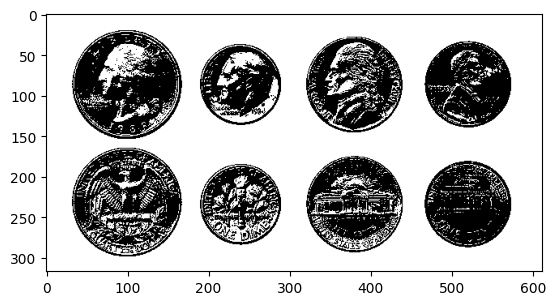

In [9]:
th, output_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(output_im, cmap='gray')

In [10]:
print(f'Otsu algorithm selected the following threshold: {th}')

Otsu algorithm selected the following threshold: 194.0


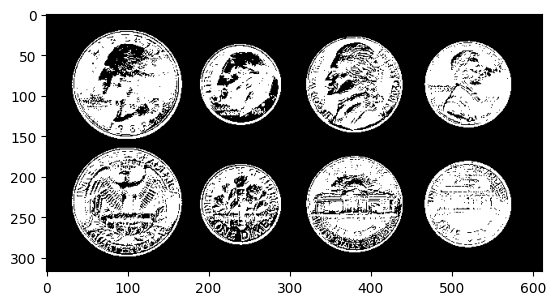

In [11]:
# Inverted
th, output_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(output_im, cmap='gray')

**Exercise 2.2**

Apply Otsu thresholding to the cell image and compare the threshold it returns to the threshold you selected in Exercise 2.1.

122.0


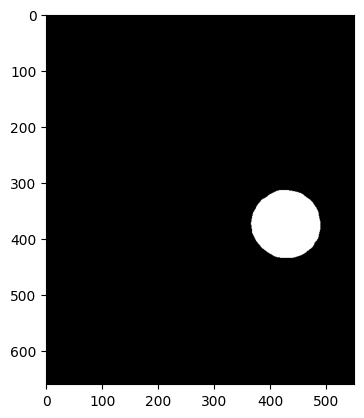

In [16]:
im_cell = skimage.data.cell()
# YOUR CODE HERE
th, output_im_cell = cv2.threshold(im_cell, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(th)
plt.imshow(output_im_cell, cmap = 'grey')

122.0


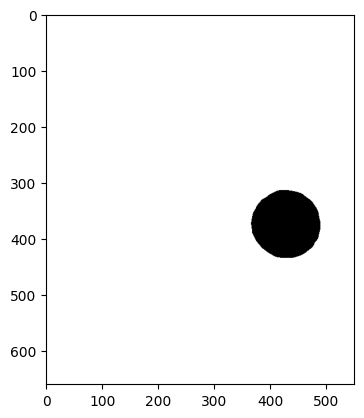

In [17]:
th, output_im_cell = cv2.threshold(im_cell, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print(th)
plt.imshow(output_im_cell, cmap = 'grey')

**Exercise 2.3**

Plot the histogram of the cell image together with the threshold returned by Otsu.

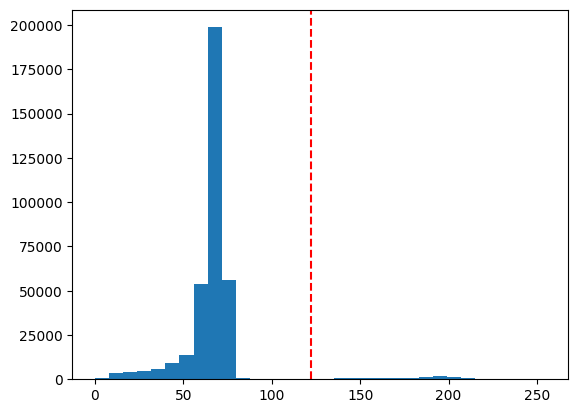

In [18]:
# YOUR CODE HERE
n, bins, patches = plt.hist(im_cell.reshape(-1,), bins=32)
plt.axvline(x=122, color='r', linestyle='--')

## 3. Adaptive Thresholding

Now what if you would like to set different thresholds to different parts of the image. You can do that with adaptive thresholding.

Adaptive thresholding is especially useful when you have uniform foreground background but different illumination. Let's demonstrate that with another sample image from skimage.

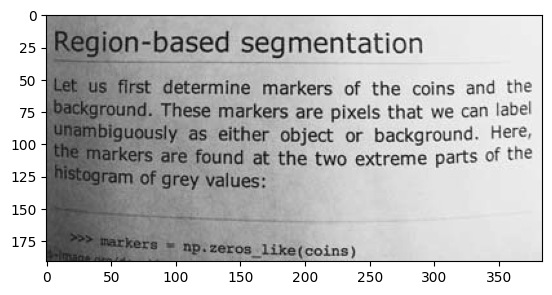

In [21]:
im_page = skimage.data.page()
plt.imshow(im_page, cmap='gray')

Let's first apply Otsu thresholding to find an optimum threshold:

The threshold is 157.0


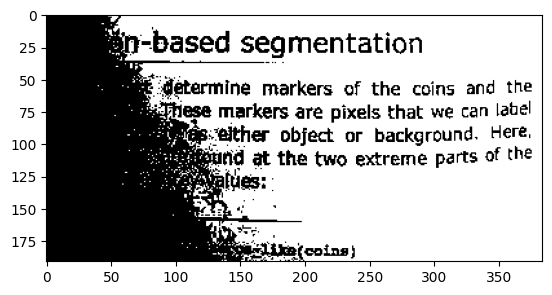

In [22]:
th, output_im = cv2.threshold(im_page, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(output_im, cmap='gray')
print(f'The threshold is {th}')

It worked for the right side of the image but not the left. So let's decrease the threshold to fix that, say to 120:

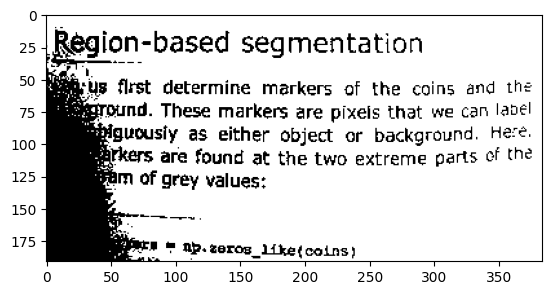

In [23]:
th, output_im = cv2.threshold(im_page, 120, 255, cv2.THRESH_BINARY)
plt.imshow(output_im, cmap='gray')

Maybe even more, let's say 80:

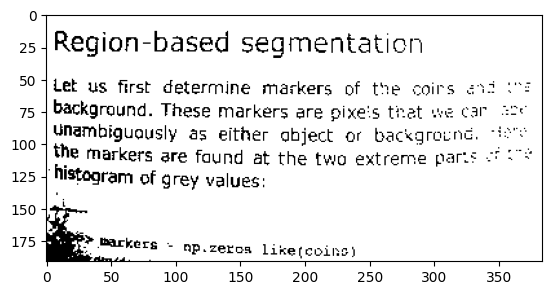

In [24]:
th, output_im = cv2.threshold(im_page, 80, 255, cv2.THRESH_BINARY)
plt.imshow(output_im, cmap='gray')

We almost fixed the issue on the left but this time we started to lose text pixels on the right side. So we need a low threshold on the left and a high threshold on the right side of the image.

This is what adaptive thresholding can do, set local thresholds:

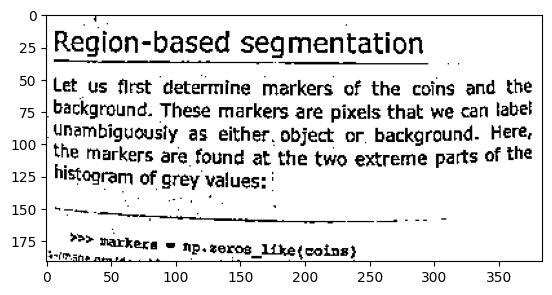

In [25]:
# Set the parameters for adaptive thresholding
# READ THE DOCUMENTATION PLEASE
block_size = 11  # Size of the neighborhood for thresholding
c = 11  # Constant subtracted from the mean

# Apply adaptive thresholding
thresholded = cv2.adaptiveThreshold(im_page, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

plt.imshow(thresholded, cmap='gray')

Much better! There are more thresholding methods. If one of these 3 methods don't work for you, take a look into other options.

In fact, scikit-image has a function that tries a bunch of different thresholding methods at once:

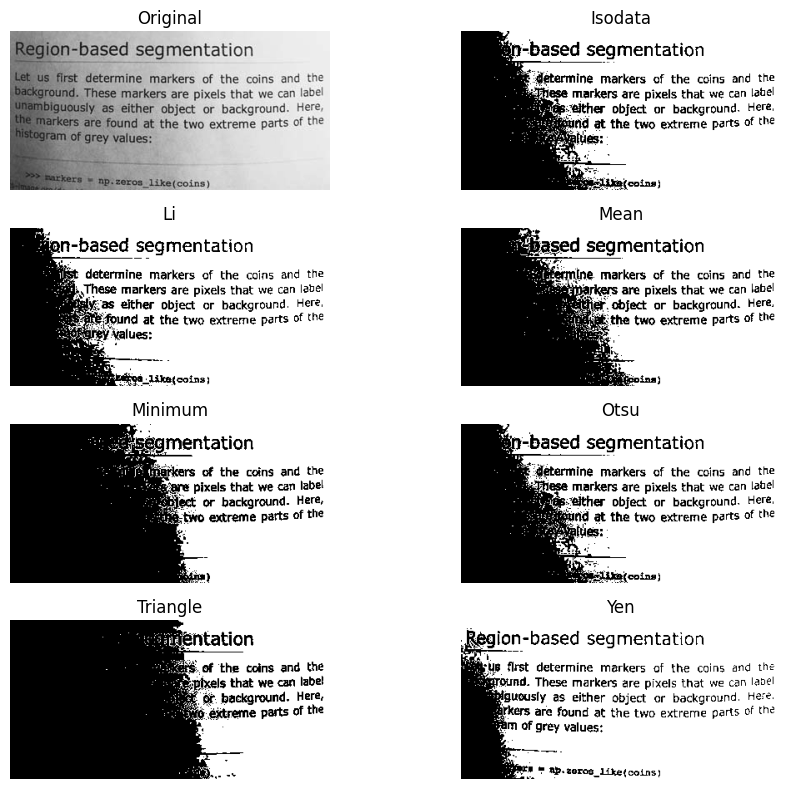

In [26]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(im_page, figsize=(10, 8), verbose=False)

but as you can see our adaptive approach worked better.

## 4. Filtering Images

Now let's get back to the issue I mentioned in the very first thresholding example:

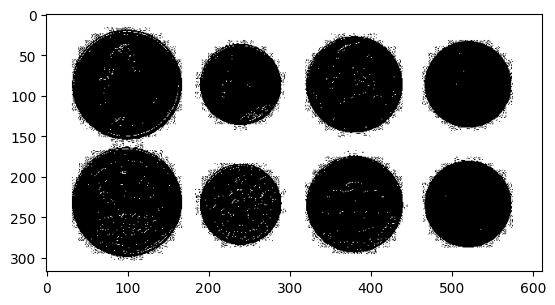

In [27]:
im = cv2.imread('images/coins.jpeg', 0)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY)
plt.imshow(output_im, cmap='gray')

and zoom into the top left coin to see what is happening:

(-0.5, 79.5, 79.5, -0.5)

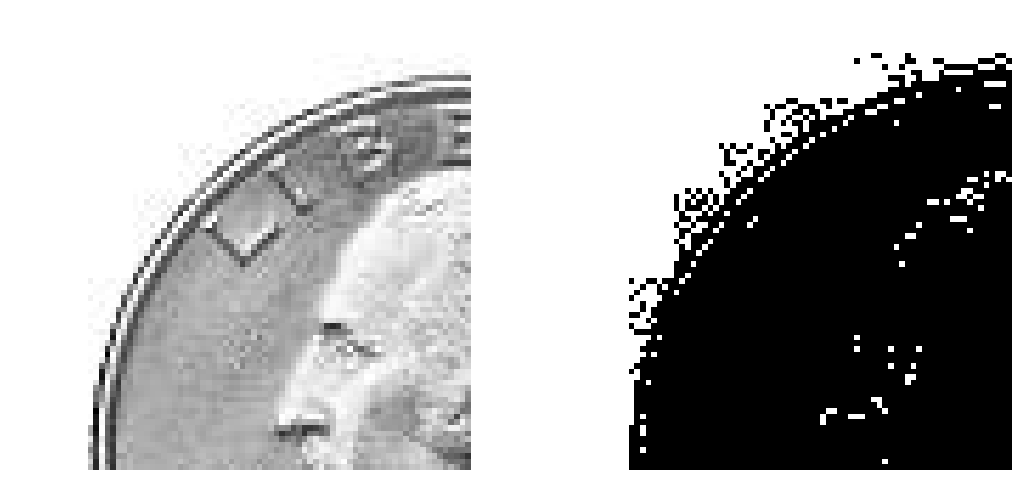

In [28]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(im[10:90, 20:100], cmap='gray')
ax[0].axis('off')
ax[1].imshow(output_im[10:90, 20:100], cmap='gray')
ax[1].axis('off')

- some pixel that belong to the background has gray shades, which means they are below the 250 threshold
- some pixel on the coin are very bright hence they have pixel values above 250.

But these pixels are only a few pixels and we can use a kernel to average them out. In others words, notice how these pixels are surrounded by the other type of pixels: a few white coin pixels are surrounded by many black coin pixels and vice versa. So if we can take the average of these pixels and set them all equal to the average, they will smoothen out.

There are many ways to do that and in Block C you have already learned about some filters. Let's start with a simple one: median blur. All the pixels in a kernel region will be replaced by their median value.

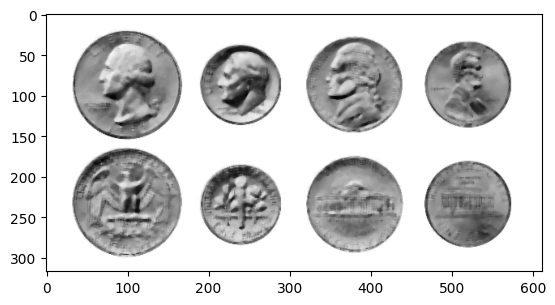

In [29]:
im_blur = cv2.medianBlur(im, 5)
plt.imshow(im_blur, cmap='gray')

notice how the coins are blurred but the edges are still sharp. Let's take a closer look to the original image and the blurred version:

(-0.5, 79.5, 79.5, -0.5)

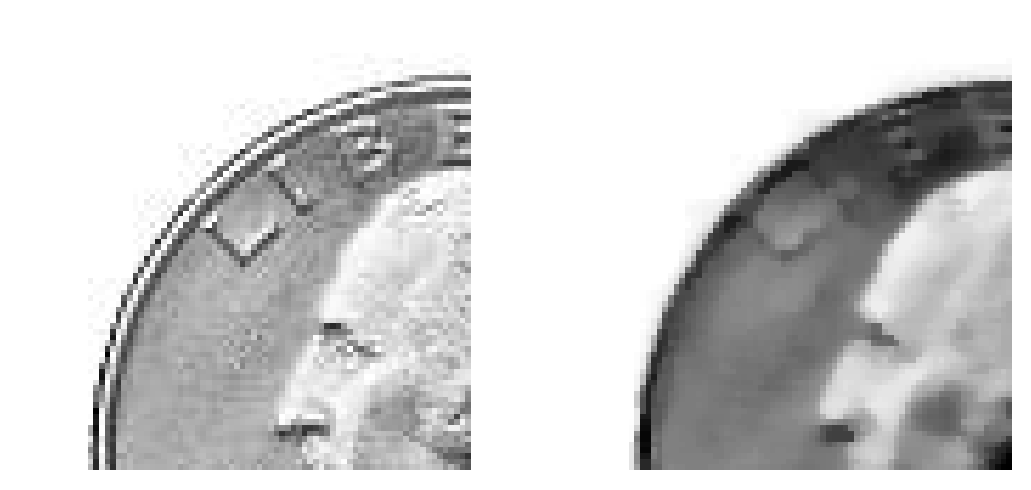

In [30]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(im[10:90, 20:100], cmap='gray')
ax[0].axis('off')
ax[1].imshow(im_blur[10:90, 20:100], cmap='gray')
ax[1].axis('off')

Indeed now gray areas in the background are much whiter and white areas on the coin are darker. Let's see what happens with thresholding:

In [37]:
th, output_im_blur = cv2.threshold(im_blur, 250, 255, cv2.THRESH_BINARY)

Text(0.5, 1.0, 'Blurred Img thresholded')

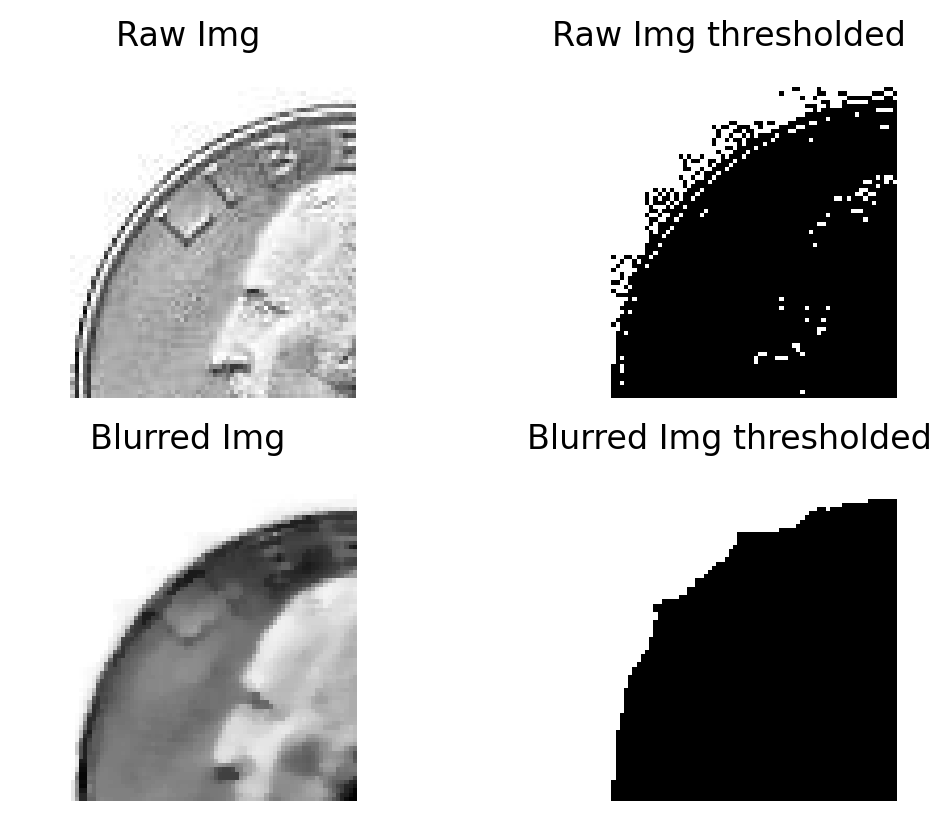

In [38]:
fig, ax = plt.subplots(2, 2, dpi=200)
ax[0, 0].imshow(im[10:90, 20:100], cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Raw Img')
ax[0, 1].imshow(output_im[10:90, 20:100], cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('Raw Img thresholded')
ax[1, 0].imshow(im_blur[10:90, 20:100], cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('Blurred Img')
ax[1, 1].imshow(output_im_blur[10:90, 20:100], cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('Blurred Img thresholded')

as you can see the foreground and the background is separated clearly.

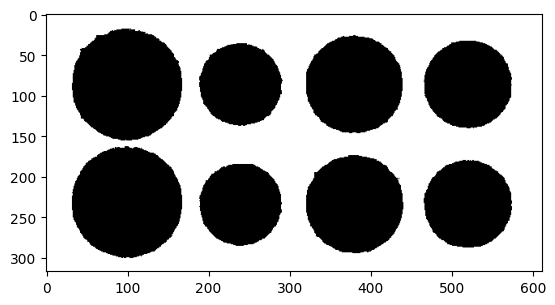

In [34]:
plt.imshow(output_im_blur, cmap='gray')

There other spatial filters you can try (e.g. `cv2.GaussianBlur`) refer to the OpenCV documentation. But you are not limited to the kernels these operations provide. You can convolve any kernel over the image as follows:

In [39]:
im = cv2.imread('images/coins.jpeg', 0)

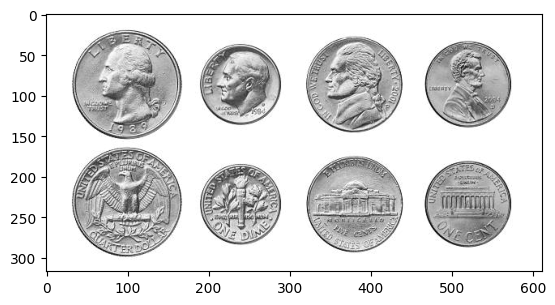

In [40]:
plt.imshow(im, cmap='gray')

In [41]:
kernel = np.ones((5, 5))/25
kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

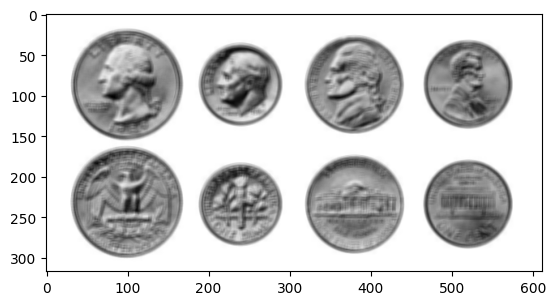

In [42]:
# when ddepth=-1, the output image will have the same depth as the source.
output = cv2.filter2D(im, -1, kernel)
plt.imshow(output, cmap='gray')

What we have covered so far is called spatial filtering. There is also frequency filtering, which is not covered in this notebook but it is important be aware of its existence.

**Exercise 2.4**

Apply median and gaussian filtering to the camera image.

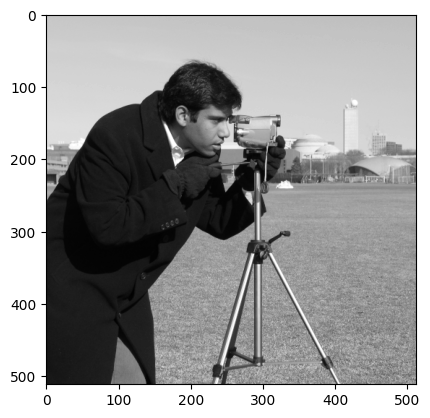

In [43]:
im_camera = skimage.data.camera()
plt.imshow(im_camera, cmap='gray')

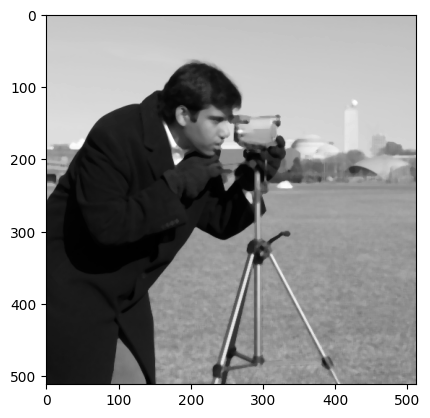

In [50]:
# YOUR CODE HERE
output = cv2.medianBlur(im_camera, 5)
plt.imshow(output, cmap = 'grey')

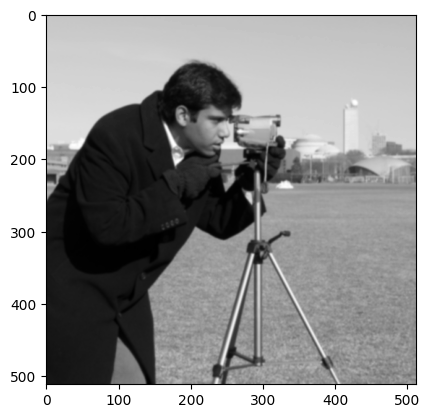

In [59]:
output_2 = cv2.GaussianBlur(im_camera, (5, 5), sigmaX=1)
plt.imshow(output_2, cmap = 'grey')